In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from comet_ml import API
import os 
import pickle
from ift6758.features import FeatureEng
from ift6758.training.plot import plot_all
import torch

# Evaluation on test set

#### Prepare variables

In [3]:
workspace='ift6758-a5-nhl'
out_folder = '../../test/'
model_pkl_file_name = 'model.pkl'
model_pt_file_name = 'model.pt'
clean_data_path = '../../ift6758/data/json_clean/'
models_dict_regular = {}
models_dict_playoff = {}

top_18_features = ['empty_net','distance_goal','shot_type_Wrap-around','y','shot_type_Slap_Shot','shot_type_Snap_Shot','period','shot_type_Deflected','prev_type_HIT','time_since_prev','angle_shot','shot_type_Tip-In','prev_type_GIVEAWAY','shot_type_Wrist_Shot','game_seconds','angle_change','speed','prev_type_SHOT']
registered_models_to_skip = ['xgboost_classifier_allfeatures']

In [4]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from ift6758.training import Net
import pandas as pd

nn_configs = {
    'small_nn_1': [32, 16],
    'small_nn_2': [64],
    'small_nn_3': [64, 64],
    'small_nn_4': [256, 128],
    'deeper_nn_1': [256, 128, 64, 64, 32],
    'deeper_nn_2': [512, 256, 128, 64, 32, 16],
    }

def find_hidden_layers(exp_name):
    for config, hidden_layers in nn_configs.items():
        if config in exp_name:
            return hidden_layers

def generate_test_tensor(X_test):
    # Get Data
    train_val = pd.read_pickle('./TrainValSets2.pkl')
    X_all = train_val.drop(['is_goal'], axis=1)
    y_all = train_val['is_goal']

    # Split into train val
    X_train, _, _, _ = train_test_split(X_all, y_all, test_size=0.3, random_state=42)

    # Create dataloaders for NN
    # Feature Scaling
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Converting to PyTorch tensors
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

    return X_test_tensor


### Get Test data

In [5]:
feature_eng = FeatureEng(clean_data_path)
test_data = feature_eng.getTestSet(2020)
test_data = feature_eng.encodeCategories(test_data, ['shot_type', 'prev_type'])
test_data = test_data.rename(columns = {'shot_type_Slap Shot':'shot_type_Slap_Shot', 'shot_type_Snap Shot':'shot_type_Snap_Shot', 'shot_type_Wrist Shot':'shot_type_Wrist_Shot'})
test_data_regular = test_data[test_data['game_id'].astype(str).str.contains('\d\d\d\d02\d\d\d\d', regex=True)]
test_data_playoff = test_data[test_data['game_id'].astype(str).str.contains('\d\d\d\d03\d\d\d\d', regex=True)]

X_test_regular = test_data_regular.drop(['is_goal', 'game_id'], axis=1)
X_test_playoff = test_data_playoff.drop(['is_goal', 'game_id'], axis=1)
y_test_regular = test_data_regular['is_goal']
y_test_playoff = test_data_playoff['is_goal']

### Get model list in comet registry

In [6]:
# Connect to the comet API
api = API(api_key=os.environ.get('COMET_API_KEY'))

# Retrieve registered model list
model_list = api.get_registry_model_names(workspace=workspace)

### Iterate over each model and run on test set

In [7]:
for model_name in model_list:
    if model_name in registered_models_to_skip:
        continue

    # Get model object from comet
    comet_model = api.get_model(workspace=workspace, model_name=model_name)

    # Retrieve latest version
    last_version = comet_model.find_versions()[0]
    print(f'Found version {last_version} for model {model_name}')

    # Download model
    download_folder = os.path.join(out_folder, model_name)
    comet_model.download(version=last_version, output_folder=download_folder, expand=True)
    model_file_path = os.path.join(download_folder, model_pkl_file_name)

    # Get features to keep
    experiment_key = comet_model.get_details(last_version)['experimentKey']
    exp = api.get_experiment_by_key(experiment_key)
    tags = exp.get_tags()

    if 'AllFeatures' in tags:
        X_test_selected_regular = X_test_regular
        X_test_selected_playoff = X_test_playoff
    elif 'RFECV_top18' in tags:
        X_test_selected_regular = X_test_regular[top_18_features]
        X_test_selected_playoff = X_test_playoff[top_18_features]
    elif 'distance_goal' in tags and 'angle_shot' in tags:
        X_test_selected_regular = X_test_regular[['distance_goal', 'angle_shot']]
        X_test_selected_regular = X_test_selected_regular.rename(columns={'distance_goal': 'distance', 'angle_shot': 'angle'})
        X_test_selected_playoff = X_test_playoff[['distance_goal', 'angle_shot']]
        X_test_selected_playoff = X_test_selected_playoff.rename(columns={'distance_goal': 'distance', 'angle_shot': 'angle'})
    elif 'distance_goal' in tags:
        X_test_selected_regular = X_test_regular['distance_goal'].values.reshape(-1, 1)
        X_test_selected_playoff = X_test_playoff['distance_goal'].values.reshape(-1, 1)
    elif 'angle_shot' in tags:
        X_test_selected_regular = X_test_regular['angle_shot'].values.reshape(-1, 1)
        X_test_selected_playoff = X_test_playoff['angle_shot'].values.reshape(-1, 1)
    else:
        X_test_selected_regular = X_test_regular
        X_test_selected_playoff = X_test_playoff

    # Load model
    is_torch_model = False
    if os.path.exists(model_file_path): 
        clf = pickle.load(open(model_file_path, 'rb'))
    else:
        model_file_path = os.path.join(download_folder, model_pt_file_name)
        name = exp.get_name()
        is_torch_model = True
        hidden_layers = find_hidden_layers(name)
        clf = Net(X_test_selected_regular.shape[1], hidden_layers, 1)
        clf.load_state_dict(torch.load(model_file_path, map_location=torch.device('cpu')))

    # Evaluate model on test set
    if is_torch_model:
        y_pred_prob_regular = clf(generate_test_tensor(X_test_selected_regular).to(clf.device)).cpu().detach().numpy()[:, 0]
        y_pred_prob_playoff = clf(generate_test_tensor(X_test_selected_playoff).to(clf.device)).cpu().detach().numpy()[:, 0]
    else:
        y_pred_prob_regular = clf.predict_proba(X_test_selected_regular)[:, 1]
        y_pred_prob_playoff = clf.predict_proba(X_test_selected_playoff)[:, 1]

    models_dict_regular[model_name] = y_pred_prob_regular
    models_dict_playoff[model_name] = y_pred_prob_playoff

Found version 1.0.2 for model best_custom
Found version 1.0.0 for model logisticregression_angle
Found version 1.0.0 for model logisticregression_distance
Found version 1.0.0 for model logisticregression_distance-angle
Found version 1.0.0 for model rfecv_top18


### Plot results

#### Regular season

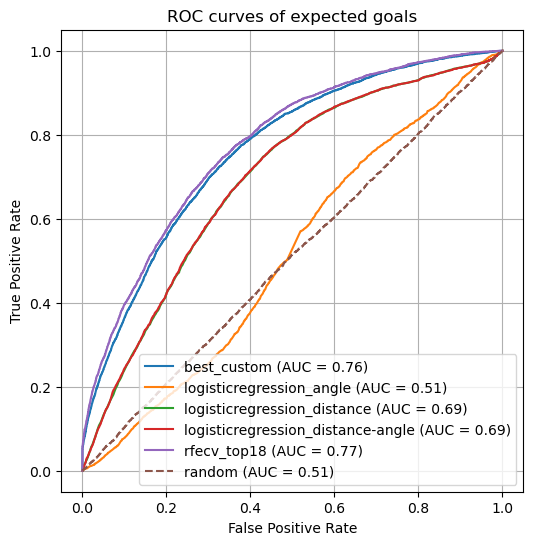

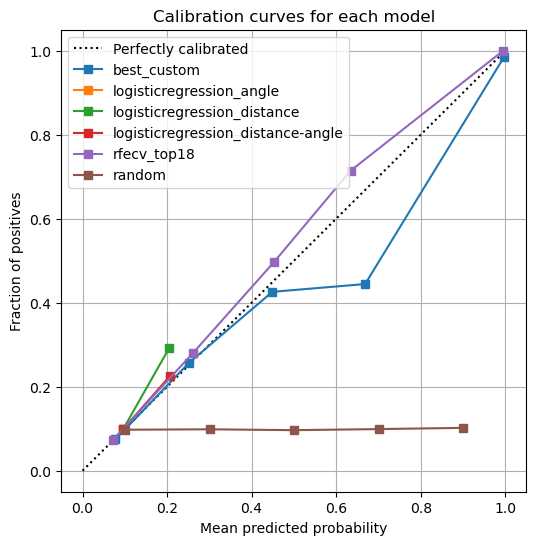

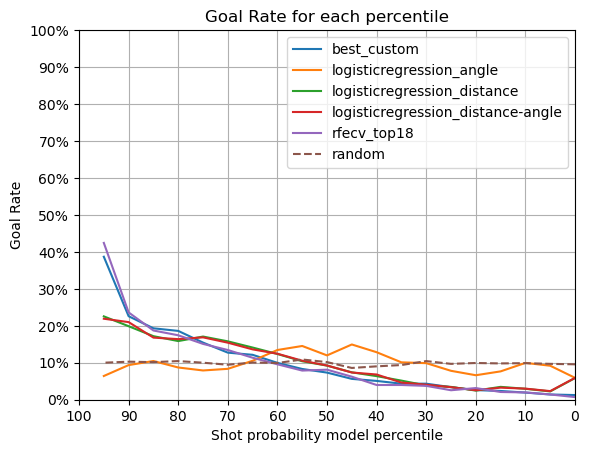

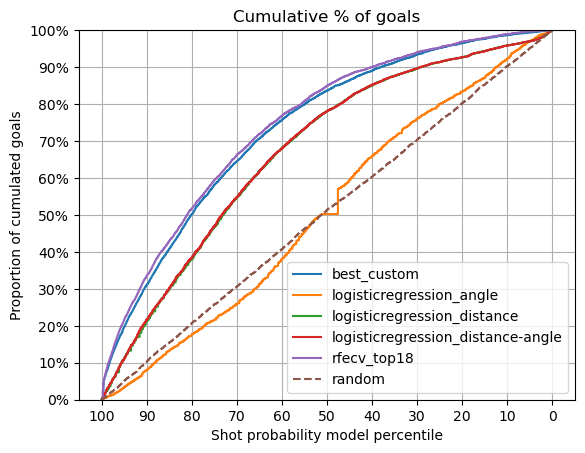

In [8]:
plot_all(models_dict_regular, y_test_regular, save_to_folder=os.path.join(out_folder, 'TestRegular'))

#### Playoffs

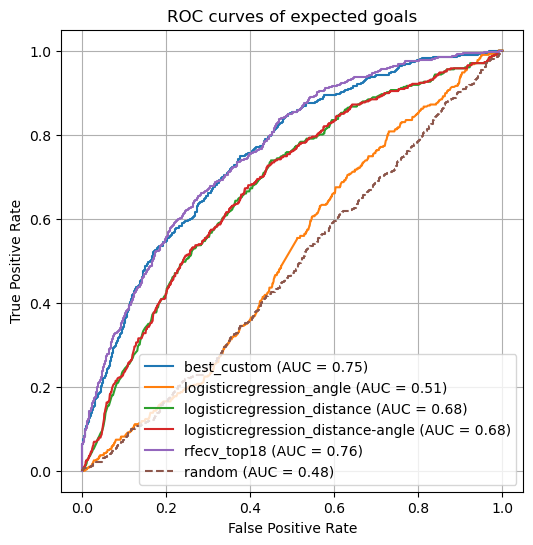

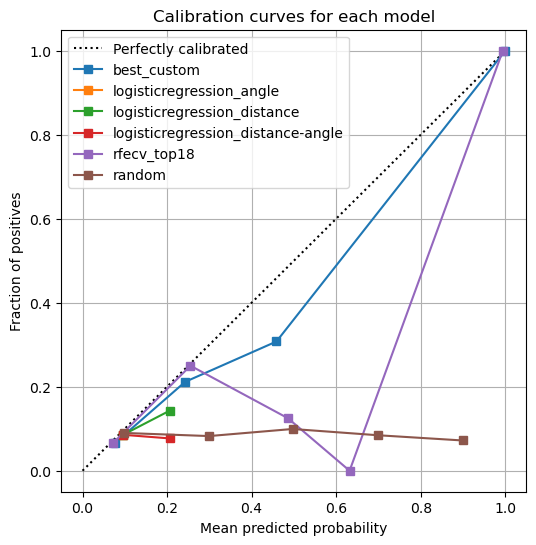

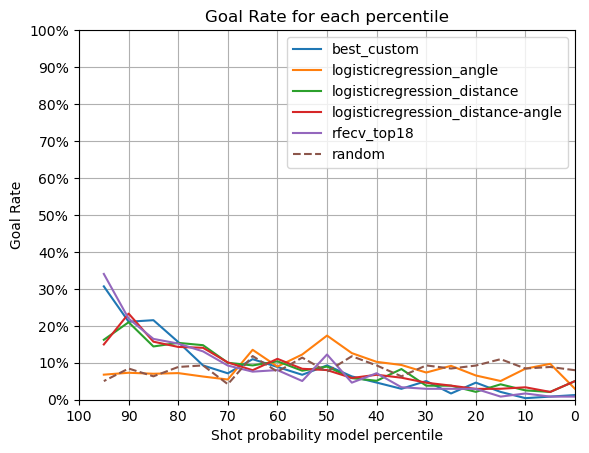

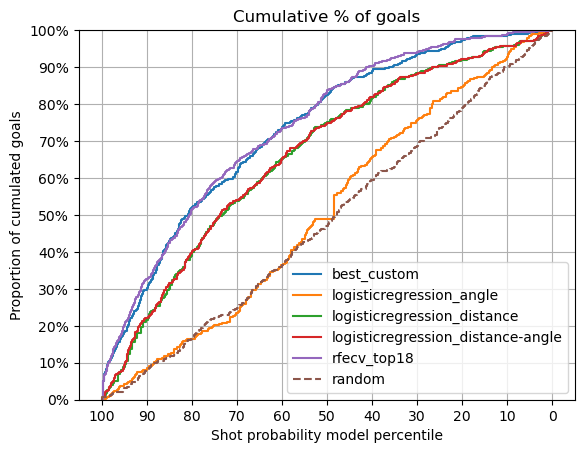

In [9]:
plot_all(models_dict_playoff, y_test_playoff, save_to_folder=os.path.join(out_folder, 'TestPlayoff'))